## Import Required Libraries

In [1]:
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import BCELoss

from models.basic_gan import create_generator, create_discriminator


## Define Helper Functions

In [2]:
def create_mixed_batch(generator, batch_size, latent_dim=100, device="cpu"):
    """
    Create a training batch with equal parts real and fake images.

    Args:
        generator: Generator model
        batch_size: Total batch size (will be split: batch_size//2 real, batch_size//2 fake)
        latent_dim: Dimension of latent space
        device: 'cpu' or 'cuda'

    Returns:
        mixed_images: Tensor of shape (batch_size, 1, 28, 28)
        mixed_targets: Ground truth labels (1=real, 0=fake) shape (batch_size, 1)
    """
    half_batch = batch_size // 2

    # Create fake real images (in practice, load from MNIST)
    real_images = torch.randn(half_batch, 1, 28, 28, device=device) * 0.5 + 0.5

    # Generate fake images
    noise = torch.randn(half_batch, latent_dim, device=device)
    with torch.no_grad():
        fake_images = generator(noise)
        # Reshape from (batch, 784) to (batch, 1, 28, 28)
        fake_images = fake_images.view(-1, 1, 28, 28)

    # Mix real and fake
    mixed_images = torch.cat([real_images, fake_images], dim=0)

    # Create labels: 1 for real, 0 for fake
    real_targets = torch.ones(half_batch, 1, device=device)
    fake_targets = torch.zeros(half_batch, 1, device=device)
    mixed_targets = torch.cat([real_targets, fake_targets], dim=0)

    return mixed_images, mixed_targets


In [3]:
def analyze_predictions(predictions, mixed_targets, half_batch):
    """
    Analyze how well the discriminator distinguished real from fake.

    Args:
        predictions: Discriminator output (batch_size, 1)
        mixed_targets: Ground truth (batch_size, 1)
        half_batch: Number of real/fake samples each
    """
    # Separate predictions
    real_preds = predictions[:half_batch]
    fake_preds = predictions[half_batch:]

    # Count correct classifications (threshold at 0.5)
    real_correct = (real_preds > 0.5).sum().item()
    fake_correct = (fake_preds < 0.5).sum().item()

    print(f"\nDiscriminator Performance (untrained):")
    print(
        f"  Real images predicted as real: {real_correct}/{half_batch} ({100*real_correct/half_batch:.0f}%)"
    )
    print(
        f"  Fake images predicted as fake: {fake_correct}/{half_batch} ({100*fake_correct/half_batch:.0f}%)"
    )

    # Show individual values
    print(f"\n  Real image probabilities: {real_preds.squeeze().tolist()}")
    print(f"  Fake image probabilities: {fake_preds.squeeze().tolist()}")


## Main Exercise

### Configuration

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


### Step 1: Create Generator and Discriminator

In [6]:
print("\n[1] Creating Generator and Discriminator...")
generator = create_generator(latent_dim=100, device=device)
generator.eval()

discriminator = create_discriminator(device=device)
discriminator.eval()
print("   Models created")



[1] Creating Generator and Discriminator...
   Models created


### Step 2: Create Mixed Batch (Real + Fake)

In [7]:
print("\n[2] Creating mixed batch (real + fake images)...")
batch_size = 16
mixed_images, mixed_targets = create_mixed_batch(
    generator, batch_size, latent_dim=100, device=device
)
print(f"    Mixed batch shape: {mixed_images.shape}")
print(f"    Targets shape: {mixed_targets.shape}")
print(f"    Real images: first {batch_size//2}")
print(f"    Fake images: last {batch_size//2}")



[2] Creating mixed batch (real + fake images)...
    Mixed batch shape: torch.Size([16, 1, 28, 28])
    Targets shape: torch.Size([16, 1])
    Real images: first 8
    Fake images: last 8


### Step 3: Discriminator Predictions

In [8]:
print("\n[3] Running discriminator on mixed batch...")
with torch.no_grad():
    predictions = discriminator(mixed_images)
print(f"    Predictions shape: {predictions.shape}")
print(f"    Prediction range: [{predictions.min():.3f}, {predictions.max():.3f}]")



[3] Running discriminator on mixed batch...
    Predictions shape: torch.Size([16, 1])
    Prediction range: [0.445, 0.490]


### Step 4: Compute Binary Cross-Entropy Loss

In [9]:
print("\n[4] Computing Binary Cross-Entropy loss...")
criterion = BCELoss()
loss = criterion(predictions, mixed_targets)
print(f"    BCE Loss: {loss.item():.4f}")
print(f"    (High loss = discriminator confused; this is expected before training!)")



[4] Computing Binary Cross-Entropy loss...
    BCE Loss: 0.7160
    (High loss = discriminator confused; this is expected before training!)


### Step 5: Analyze Performance

In [10]:
print("\n[5] Analyzing discriminator performance...")
half_batch = batch_size // 2
analyze_predictions(predictions, mixed_targets, half_batch)



[5] Analyzing discriminator performance...

Discriminator Performance (untrained):
  Real images predicted as real: 0/8 (0%)
  Fake images predicted as fake: 8/8 (100%)

  Real image probabilities: [0.47163650393486023, 0.47897887229919434, 0.4648057520389557, 0.44903168082237244, 0.476656973361969, 0.4700373411178589, 0.44521862268447876, 0.4805898368358612]
  Fake image probabilities: [0.49026164412498474, 0.48749300837516785, 0.4887816905975342, 0.4878542423248291, 0.48896971344947815, 0.48887374997138977, 0.48895323276519775, 0.48734742403030396]


### Step 6: Visualization


[6] Visualizing predictions...


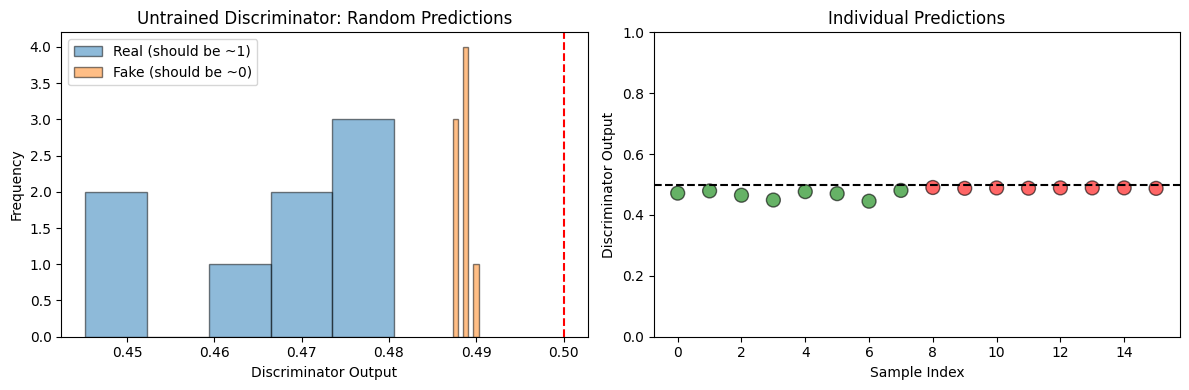

In [11]:
print("\n[6] Visualizing predictions...")
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Histogram of predictions
real_preds = predictions[:half_batch].cpu().numpy().flatten()
fake_preds = predictions[half_batch:].cpu().numpy().flatten()

axes[0].hist(
    real_preds, bins=5, alpha=0.5, label="Real (should be ~1)", edgecolor="black"
)
axes[0].hist(
    fake_preds, bins=5, alpha=0.5, label="Fake (should be ~0)", edgecolor="black"
)
axes[0].set_xlabel("Discriminator Output")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Untrained Discriminator: Random Predictions")
axes[0].legend()
axes[0].axvline(0.5, color="red", linestyle="--", label="Decision boundary")

# Plot 2: Individual predictions
all_preds = predictions.cpu().numpy().flatten()
colors = ["green" if i < half_batch else "red" for i in range(batch_size)]
labels = ["Real" if i < half_batch else "Fake" for i in range(batch_size)]

axes[1].scatter(
    range(batch_size), all_preds, c=colors, s=100, alpha=0.6, edgecolor="black"
)
axes[1].axhline(0.5, color="black", linestyle="--", label="Decision boundary")
axes[1].set_xlabel("Sample Index")
axes[1].set_ylabel("Discriminator Output")
axes[1].set_title("Individual Predictions")
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()


## Summary

In [12]:
print("\n Exercise complete!")
print("\nKey Observations:")
print("- Untrained discriminator gives ~50% accuracy (guessing)")
print("- Loss is high (~0.69 for random predictions)")
print("- This is the baseline before adversarial training")
print("- After training with a generator, loss should decrease significantly")



 Exercise complete!

Key Observations:
- Untrained discriminator gives ~50% accuracy (guessing)
- Loss is high (~0.69 for random predictions)
- This is the baseline before adversarial training
- After training with a generator, loss should decrease significantly
